In [2]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, MultiBasisDataLoader

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence
from datetime import datetime

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt


data_dir = "data"
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Data resides in        : {data_dir}")
print(f"Model will be saved to : {model_dir}")

Data resides in        : data
Model will be saved to : models


In [3]:
import jax, jax.numpy as jnp
import flax.linen as nn
from typing import Any, Dict, Tuple
PRNGKey = jax.random.PRNGKey  # for brevity


class RBM(nn.Module):
    """Weight-modulated (FiLM) conditional RBM."""
    n_visible: int
    n_hidden: int
    k: int = 1                     # Gibbs steps
    T: float = 1.0                 # temperature
    mlp_dim: int = 32              # hidden dim of modulation MLP

    # ---------------------------------------------------- parameters
    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.n_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.n_hidden,))

        # tiny FiLM generator:  cond_bits  -->  (γ | β)  (size 2·n_hidden)
        self.film_mlp = (
            nn.Sequential([
            nn.Dense(self.mlp_dim), nn.relu,
            nn.Dense(2 * self.n_hidden, kernel_init=nn.initializers.zeros)  # start with γ≈0, β≈0
        ]))

    # ---------------------------------------------------- public call
    def __call__(self, data: jnp.ndarray, aux: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        """
        data.shape        = (B, Q, 3)
        aux = {
            "gibbs_chain": (B, n_visible)  -- current persistent chain
            "key":          PRNGKey
            "cond_mask":    (n_visible,) bool
            "cond_vals":    (B, n_visible)  frozen basis bits
        }
        """
        B = data.shape[0]
        cond_mask: jnp.ndarray = aux["cond_mask"]
        cond_vals: jnp.ndarray = aux["cond_vals"]            # already flat
        v_data = data.reshape(B, -1)
        v_data = v_data.at[:, cond_mask].set(cond_vals[:, cond_mask])

        # ---------- FiLM modulation ---------------------------------
        phi = self.film_mlp(cond_vals[:, cond_mask])         # (B, 2·n_hidden)
        gamma, beta = jnp.split(phi, 2, axis=-1)             # (B, n_hidden)
        gamma = 1.0 + gamma                                  # γ≈1 at init

        # pre-compute v_sum once for efficiency
        v_sum = lambda v: jnp.sum(v, axis=1, keepdims=True)  # (B,1)

        # helper to get v @ W_eff without materialising W_eff
        def vW(v):
            return (v @ self.W) * gamma + beta * v_sum(v)    # (B, n_hidden)

        def hW_T(h):
            return (
                    (h * gamma) @ self.W.T +           # (B, n_visible)
                    (h * beta) @ jnp.ones((self.n_hidden, 1))
            )                                      # broadcast trick

        # ---------- Gibbs sampler (k steps) -------------------------
        def one_step(state):
            v, key = state
            key, hk, vk = jax.random.split(key, 3)
            h = jax.random.bernoulli(hk, jax.nn.sigmoid((vW(v) + self.c) / self.T)
                                     ).astype(jnp.float32)
            v_prop = jax.random.bernoulli(
                vk,
                jax.nn.sigmoid((hW_T(h) + self.b) / self.T)
            ).astype(jnp.float32)
            v_prop = v_prop.at[:, cond_mask].set(cond_vals[:, cond_mask])
            return v_prop, key

        gibbs_chain, key = jax.lax.fori_loop(
            0, self.k, lambda _, s: one_step(s), (aux["gibbs_chain"], aux["key"])
        )
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain)

        # ---------- Free-energy difference --------------------------
        def free_energy(v):
            return -(v @ self.b) - jnp.sum(
                jax.nn.softplus(vW(v) + self.c), axis=-1)

        loss = jnp.mean(free_energy(v_data)) \
               - jnp.mean(free_energy(gibbs_chain))

        return loss, {"gibbs_chain": gibbs_chain, "key": key}

    # ---------------------------------------------------- sampling
    @nn.nowrap
    def generate(self,
                 n_samples: int,
                 T_sched: jnp.ndarray,
                 cond_mask: jnp.ndarray,
                 cond_vals: jnp.ndarray,
                 key: PRNGKey) -> jnp.ndarray:
        """
        Draw n_samples configurations given fixed basis bits cond_vals.
        """
        key, k0 = jax.random.split(key)
        v = jax.random.bernoulli(k0, 0.5, (n_samples, self.n_visible))
        v = v.at[:, cond_mask].set(cond_vals[:, cond_mask])

        # FiLM vectors
        phi = self.film_mlp(cond_vals[:, cond_mask])
        gamma, beta = jnp.split(phi, 2, axis=-1)
        gamma = 1.0 + gamma

        v_sum = lambda x: jnp.sum(x, axis=1, keepdims=True)

        def vW(x):  # reuse helpers inside generate
            return (x @ self.W) * gamma + beta * v_sum(x)

        def hW_T(h):
            return (
                    (h * gamma) @ self.W.T +
                    (h * beta) @ jnp.ones((self.n_hidden, 1))
            )

        def step(i, state):
            v_s, key_s = state
            key_s, hk, vk = jax.random.split(key_s, 3)
            h = jax.random.bernoulli(hk, jax.nn.sigmoid((vW(v_s) + self.c) / T_sched[i]))
            v_prop = jax.random.bernoulli(
                vk,
                jax.nn.sigmoid((hW_T(h) + self.b) / T_sched[i])
            ).astype(jnp.float32)
            v_prop = v_prop.at[:, cond_mask].set(cond_vals[:, cond_mask])
            return v_prop, key_s

        v_final, _ = jax.lax.fori_loop(0, len(T_sched), step, (v, key))
        return v_final

In [4]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch: jnp.ndarray,
        gibbs_chain: jnp.ndarray,
        key: PRNGKey,
        chain_reset_frac: float) -> Tuple[TrainState, jnp.ndarray, jnp.ndarray, PRNGKey]:

    key, key_reset, key_sample = jax.random.split(key, 3)

    # Reset mask: which chains to replace
    reset_mask = jax.random.bernoulli(key_reset, p=chain_reset_frac, shape=(batch_size, 1))

    # Sample from batch — shape (batch_size,)
    sample_idxs = jax.random.randint(key_sample, shape=(batch_size,), minval=0, maxval=batch.shape[0])
    sampled_onehots = batch[sample_idxs]  # shape (batch_size, n_visible)

    # Replace according to mask
    reset_chain = jnp.where(reset_mask, sampled_onehots, gibbs_chain)


    aux_vars = {"gibbs_chain": reset_chain, "key": key}
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, aux_vars["gibbs_chain"], aux_vars["key"]


def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        gibbs_chain: jnp.ndarray,
        num_epochs: int,
        key: PRNGKey) -> Tuple[TrainState, Dict[int, float]]:

    metrics = {}
    for epoch in range(num_epochs):
        tot_loss = tot_entropy_chain = tot_modes_chain = 0.0
        batches = 0

        for base_batches, bases in loader:
            if base_batches.shape[0] != 1 or bases.shape[0] != 1:
                raise ValueError(f"Expected exactly one basis, got: {base_batches.shape[0]} bases")

            if not jnp.all(bases[0] == 0):
                raise ValueError(f"Only Z basis supported for amplitude RBM")

            batch = base_batches[0]

            chain_reset_frac = 0.1
            state, loss, gibbs_chain, key = train_step_amp(state, batch, gibbs_chain, key, chain_reset_frac)

            tot_loss += float(loss)
            batches += 1

        avg_loss = tot_loss / batches
        avg_entropy_chain = tot_entropy_chain / batches
        avg_modes_chain = tot_modes_chain / batches
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(
            loss=avg_loss,
            entropy_chain=avg_entropy_chain,
            modes_chain=avg_modes_chain,
            lr=lr
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Chain Reset Frac.: {chain_reset_frac:.3f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [5]:
#### LOADING DATA IN Z BASIS ####

data_dict_amp = load_measurements(data_dir, "w_*.txt")

keys_amp = [k for k in data_dict_amp if re.fullmatch(r"^Z+$", k)]
dict_amp = {k: data_dict_amp[k] for k in keys_amp}

empirical_freq_amp = jnp.zeros(next(iter(dict_amp.values())).shape[1])
num_total = 0

for arr in dict_amp.values():
    empirical_freq_amp += jnp.sum(arr, axis=0)
    num_total += arr.shape[0]

empirical_freq_amp /= num_total
empirical_freq_amp

Array([0.1265625 , 0.1221875 , 0.1275    , 0.12375   , 0.13      ,
       0.12859374, 0.11953125, 0.121875  ], dtype=float32)

In [6]:
batch_size      = 64        #                                               DONE
visible_units   = 8         #                                               DONE
hidden_units    = 16        # totally sufficient to capture all modes       DONE
k_steps         = 400       # higher is generally better                    GOOD FOR NOW
init_lr         = 1e-2      #                                               DONE
final_lr        = init_lr * 0.1 #                                           DONE
num_epochs      = 2000      #                                               MORE EPOCHS EVEN OUT SAMPLING FREQUENCIES
chains          = batch_size # makes chain replacement logic easier         DONE


key_seed = PRNGKey(42)
key, key_params, key_chains, key_dummy = jax.random.split(key_seed, 4)

model_amp = RBM(visible_units, hidden_units, k=k_steps)
batch_dummy = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
aux_vars_dummy = {"gibbs_chain": jnp.zeros((batch_size, visible_units), dtype=jnp.float32), "key": key_dummy}
variables_amp = model_amp.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=batch_size, basis_encoding={'Z': 0, 'X': 1, 'Y': 2})

schedule_steps = num_epochs * len(loader_amp)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005, center_step=schedule_steps * 0.5)
optimizer_amp = optax.adam(learning_rate=lr_schedule)

state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)

# should come from data too but works for now
gibbs_chain = jax.random.bernoulli(key_chains, p=0.5, shape=(chains, visible_units)).astype(jnp.float32)

%time state_amp, metrics_amp = train_amp_rbm(state_amp, loader_amp, gibbs_chain, num_epochs, key=key, chain_reset_frac_min=0.02, chain_reset_frac_max=0.30, chain_reset_ema_alpha=0.9)

Precalculating target entropy from data.
Epoch 1/2000 │ Loss: -0.1971 │ Chain Entr.: 2.796 │ Chain Modes: 29 │ Chain Reset Frac.: 0.232 │ Learning Rate: 0.01000
Epoch 2/2000 │ Loss: -0.0306 │ Chain Entr.: 2.556 │ Chain Modes: 24 │ Chain Reset Frac.: 0.156 │ Learning Rate: 0.01000
Epoch 3/2000 │ Loss: -0.0387 │ Chain Entr.: 2.558 │ Chain Modes: 24 │ Chain Reset Frac.: 0.193 │ Learning Rate: 0.01000
Epoch 4/2000 │ Loss: -0.0169 │ Chain Entr.: 2.569 │ Chain Modes: 24 │ Chain Reset Frac.: 0.208 │ Learning Rate: 0.01000
Epoch 5/2000 │ Loss: -0.0121 │ Chain Entr.: 2.556 │ Chain Modes: 24 │ Chain Reset Frac.: 0.191 │ Learning Rate: 0.01000
Epoch 6/2000 │ Loss: -0.0025 │ Chain Entr.: 2.544 │ Chain Modes: 23 │ Chain Reset Frac.: 0.189 │ Learning Rate: 0.01000
Epoch 7/2000 │ Loss: -0.0124 │ Chain Entr.: 2.553 │ Chain Modes: 23 │ Chain Reset Frac.: 0.195 │ Learning Rate: 0.01000
Epoch 8/2000 │ Loss: +0.0152 │ Chain Entr.: 2.536 │ Chain Modes: 23 │ Chain Reset Frac.: 0.170 │ Learning Rate: 0.01000

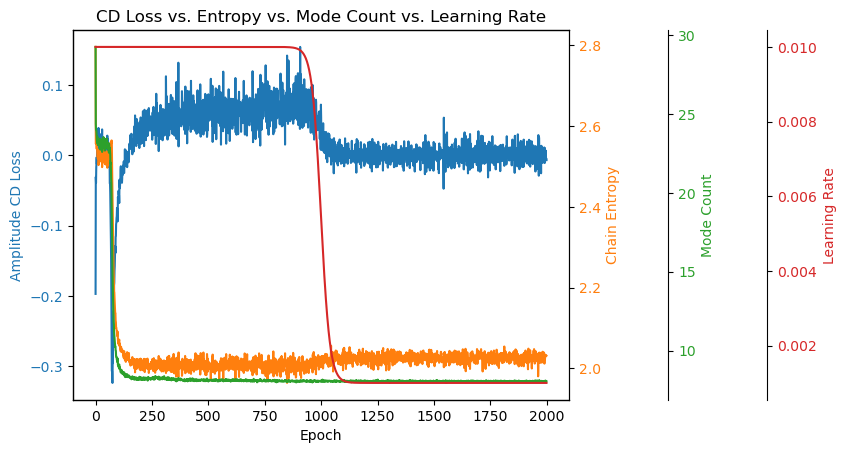

In [7]:
epochs = list(metrics_amp.keys())
loss_vals = [metrics_amp[e]['loss'] for e in epochs]
entropy_vals = [metrics_amp[e]['entropy_chain'] for e in epochs]
mode_vals = [metrics_amp[e]['modes_chain'] for e in epochs]
lr_vals = [metrics_amp[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Amplitude CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs, entropy_vals, label="Chain Entropy", color="tab:orange")
ax2.set_ylabel("Chain Entropy", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(epochs, mode_vals, label="Estimated Mode Count", color="tab:green")
ax3.set_ylabel("Mode Count", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
ax4.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax4.set_ylabel("Learning Rate", color="tab:red")
ax4.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Entropy vs. Mode Count vs. Learning Rate")
plt.show()

In [8]:
# shifting the center step to 0 we can approximate an exponential schedule if we choose the high to be
T_high = 2.0
T_low = 0.01
sampling_steps = 10000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

key_sample = PRNGKey(1234)

samples_amp = model_amp.apply(
    {"params": state_amp.params},
    n_samples=10_000,
    T_schedule=sigmoid_schedule,
    key=key_sample,
    method=RBM.generate
)

sampled_freq_amp = samples_amp.mean(0)
sampled_freq_amp

Array([0.1291    , 0.10619999, 0.15169999, 0.1268    , 0.1348    ,
       0.1282    , 0.1232    , 0.09999999], dtype=float32)

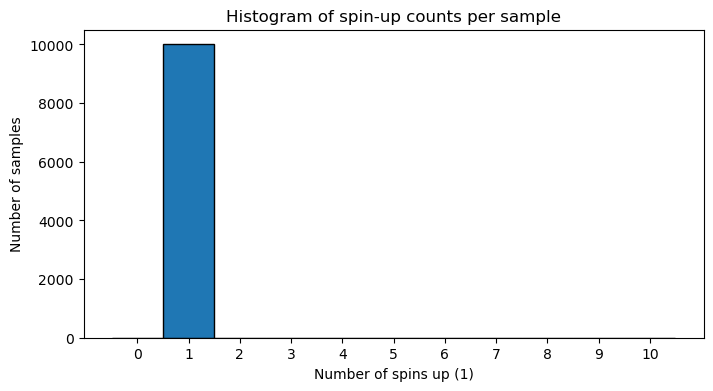

In [9]:
spin_counts = samples_amp.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

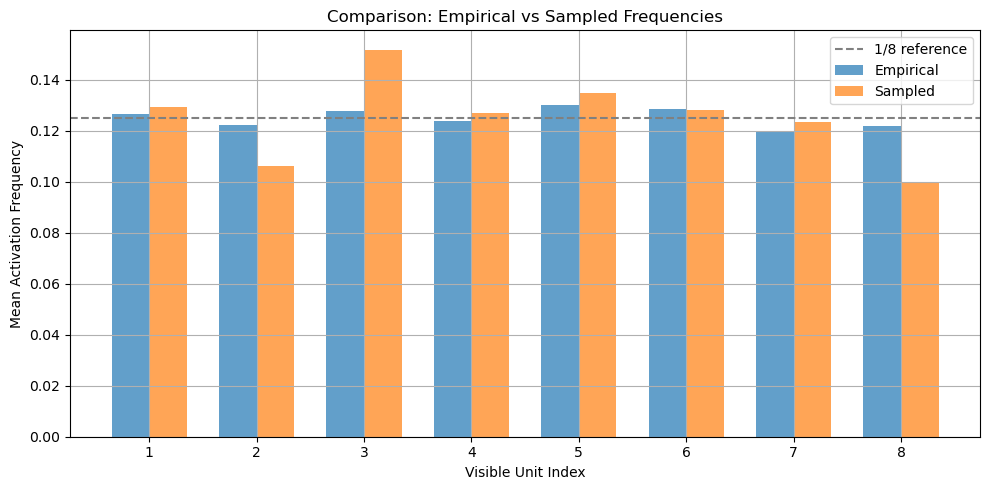

In [10]:
plt.figure(figsize=(10, 5))
x = np.arange(visible_units) + 1
width = 0.35

plt.bar(x - width/2, empirical_freq_amp, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, sampled_freq_amp, width, label="Sampled", alpha=0.7)

plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Frequency")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
timestamp = datetime.now().strftime("%Y%m%d%H%M")
model_name = f"rbm_amp_{timestamp}"

checkpoints.save_checkpoint(
    ckpt_dir=str(model_dir.resolve()),
    target=state_amp.params,
    step=0,
    prefix=model_name + "_",
    overwrite=True
)

'/Users/Tonni/Desktop/master-code/neural-quantum-tomo/case_studies/w_aug_v4/models/rbm_amp_202506081653_0'